In [1]:
import torch
import os
import pandas as pd
import numpy as np
import clip
from PIL import Image
from tqdm import tqdm
import pytorch_lightning as pl
from torch.utils.data import Dataset, DataLoader

import matplotlib.pyplot as plt
import seaborn as sns

### Read product information i.e title, brand and link to product images

In [2]:
all_details_df = pd.read_csv('amazon_dataset/clothing_shoes_jewellery/all_products.csv')
all_details_df.set_index('asin', inplace=True)

co_purchase_df = pd.read_csv('kcore5new_brand.csv')
unique_asins = co_purchase_df['asin'].unique()

image_folder_path = '/home/arnuv/amazon_dataset/clothing_shoes_jewellery/images/'

### Initialize CLIP model for generating embeddings

In [4]:
# CLIP Setup
device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load("ViT-B/32", device=device)

### Extract product title, brand and link to product images

In [5]:
titles = []
images = []
brands = []
for asin in tqdm(unique_asins):
    product = all_details_df.loc[asin]
    if not product.empty:
        brands.append(product['brand'])
        titles.append(product['title'])
        image_url = product['imUrl']
        image_name = image_url.split('/')[-1]
        images.append(os.path.join(image_folder_path, image_name))

100%|██████████| 34864/34864 [00:02<00:00, 16013.21it/s]


### Preprocess(Tokenize) title and brand information before feeding the CLIP model. 

In [6]:
# Processing Text for CLIP
text_tokens = clip.tokenize(titles, truncate = True)

# Processing Text for CLIP
brand_tokens = clip.tokenize(brands, truncate = True)

### Create image, text and brand dataloaders to read input in batches

In [8]:
class ImageDataset(Dataset):
    def __init__(self, image_paths):
        self.image_paths = image_paths

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        return self.image_paths[idx]


class TextDataset(Dataset):
    def __init__(self, text_tokens):
        self.text_tokens = text_tokens

    def __len__(self):
        return len(self.text_tokens)

    def __getitem__(self, idx):
        return self.text_tokens[idx]

image_dataset = ImageDataset(images)
text_dataset = TextDataset(text_tokens)
brand_dataset = TextDataset(brand_tokens)

image_loader = DataLoader(image_dataset, batch_size=32, shuffle=False)
text_loader = DataLoader(text_dataset, batch_size=32, shuffle=False)
brand_loader = DataLoader(brand_dataset, batch_size=32, shuffle=False)

### Create and normalize image, text and brand images

In [10]:
# Preprocessing images first before feeding the images to CLIP
def process_images(data_loader, preprocess):
    all_embeddings = []
    for image_paths in tqdm(data_loader, desc="Processing Images"):
        with torch.no_grad():
            images = [preprocess(Image.open(img_path)).unsqueeze(0).to(device) for img_path in image_paths]
            embeddings = model.encode_image(torch.cat(images))
            all_embeddings.append(embeddings)
    return torch.cat(all_embeddings)


# Text has already been preprocessed by tokenizing it in the previous cells
def process_text(data_loader):
    all_embeddings = []
    for text in tqdm(data_loader, desc="Processing Text"):
        with torch.no_grad():
            embeddings = model.encode_text(text.to(device))
            all_embeddings.append(embeddings)
    return torch.cat(all_embeddings)
    
image_embeddings = process_images(image_loader, preprocess)
image_embeddings /= image_embeddings.norm(dim=-1, keepdim=True)

text_embeddings = process_text(text_loader)
text_embeddings /= text_embeddings.norm(dim=-1, keepdim=True)

brand_embeddings = process_text(brand_loader)
brand_embeddings /= brand_embeddings.norm(dim=-1, keepdim=True)

Processing Images: 100%|██████████| 1090/1090 [02:32<00:00,  7.15it/s]


### Save image, text and brand embeddings

In [13]:
# Saving Embeddings
np.save('text_embeddings_k_5.npy_brand', text_embeddings.cpu().numpy())
np.save('brand_embeddings_k_5_brand.npy', brand_embeddings.cpu().numpy())
np.save('image_embeddings.npy_k_5_brand', image_embeddings.cpu().numpy())

### Validate CLIP Embeddings

###### Visualization to show that image embedding more similar to its title embedding than all other titles
###### x-axis is image embedding and y-axis is text embedding 

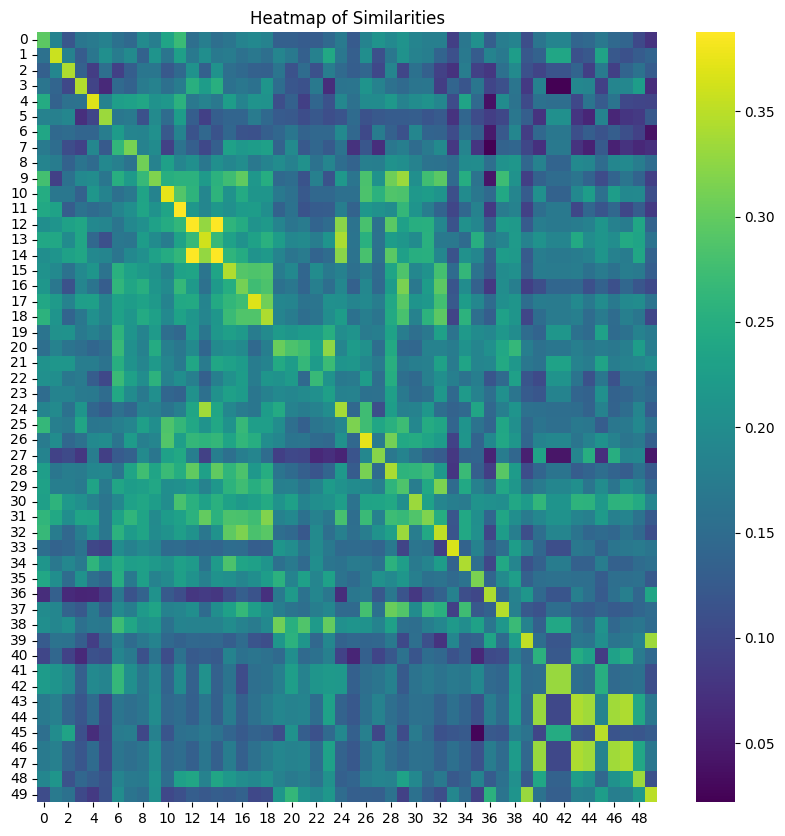

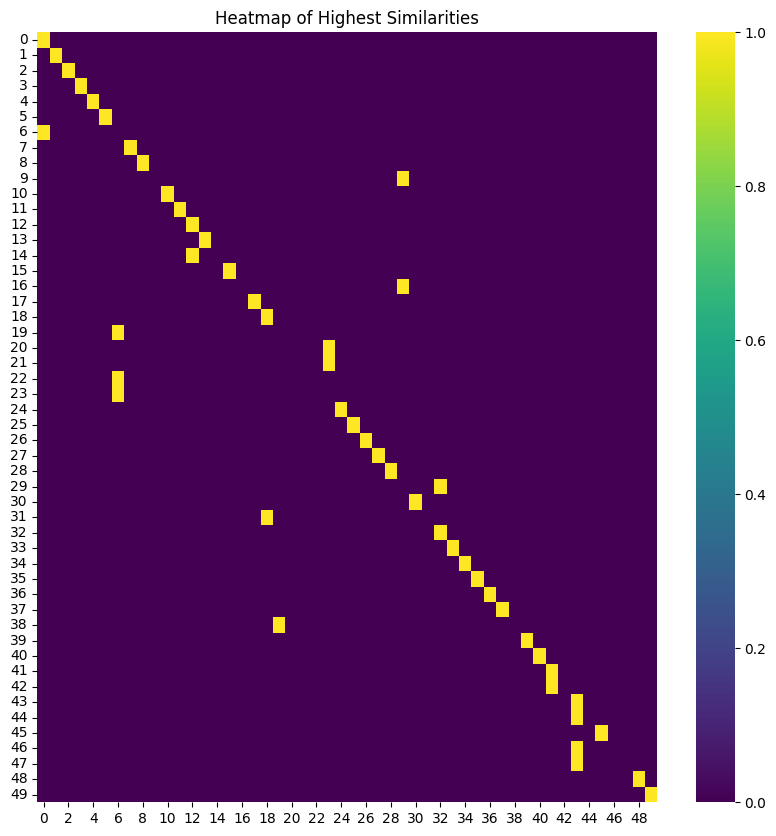

In [50]:
similarities = text_embeddings[0:50].cpu().numpy() @ image_embeddings[0:50].cpu().numpy().T

plt.figure(figsize=(10, 10))
sns.heatmap(similarities, cmap='viridis')
plt.title('Heatmap of Similarities')
plt.show()

highest_similarity_indices = np.argmax(similarities, axis=1)
binary_similarities = np.zeros_like(similarities)
binary_similarities[np.arange(similarities.shape[0]), highest_similarity_indices] = 1

plt.figure(figsize=(10, 10))
sns.heatmap(binary_similarities, cmap='viridis')
plt.title('Heatmap of Highest Similarities')
plt.show()